# Maximum Entropy Approximation - Joint distribution $P(m, p)$

(c) 2018 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

---

In [1]:
import os
import itertools
import cloudpickle
import re

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy as sp

# Import library to perform maximum entropy fits
from maxentropy.skmaxent import FeatureTransformer, MinDivergenceModel

# Import libraries to parallelize processes
from joblib import Parallel, delayed

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages # to save multipage pdf

# Seaborn, useful for graphics
import seaborn as sns

# Import the project utils
import sys
sys.path.insert(0, '../../')
import ccutils

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

tmpdir = '../../tmp/'
figdir = '../../fig/MaxEnt_approx_joint/'
datadir = '../../data/csv_maxEnt_dist/'

In [2]:
# Set PBoC plotting format
ccutils.viz.set_plotting_style()

# $\LaTeX$ macros

$\newcommand{kpon}{k^p_{\text{on}}}$
$\newcommand{kpoff}{k^p_{\text{off}}}$
$\newcommand{kron}{k^r_{\text{on}}}$
$\newcommand{kroff}{k^r_{\text{off}}}$
$\newcommand{rm}{r _m}$
$\newcommand{rp}{r _p}$
$\newcommand{gm}{\gamma _m}$
$\newcommand{gp}{\gamma _p}$
$\newcommand{mm}{\left\langle m \right\rangle}$
$\newcommand{foldchange}{\text{fold-change}}$
$\newcommand{ee}[1]{\left\langle #1 \right\rangle}$
$\newcommand{bb}[1]{\mathbf{#1}}$

## The MaxEnt approximation.

Given the difficulty at solving chemical master equations (CME) there is an extensive repertoire of approximate methods to tackle the problem of solving these equations. A particularly interesting method uses the so-called moment-expansion and maximum entropy approach to approximate distributions given knowledge of some of the moments of the distribution.

To illustrate the principle let us focus on a univariate distribution $P_X(x)$.
The $n^{\text{th}}$ moment of the distribution for a discrete set of possible
values of $x$ is given by
\begin{equation}
  \ee{x^n} \equiv \sum_x x^n P_X(x).
  \label{eq_mom_ref}
\end{equation}

Now assume that we have knowledge of the first $m$ moments $\bb{\ee{x}}_m = (
\ee{x}, \ee{x^2}, \ldots, \ee{x^m} )$. The question is then how can we use this
information to build an estimator $P_H(x \mid \bb{\ee{x}}_m)$ of the
distribution
such that
\begin{equation}
  \lim_{m \rightarrow \infty} P_H(x \mid \bb{\ee{x}}_m) \rightarrow P_X(x),
\end{equation}
i.e. that the more moments we add to our approximation, the more the estimator
distribution converges to the real distribution.

The MaxEnt principle tells us that our best guess for this estimator is to build
it on the base of maximizing the Shannon entropy, constrained by the information
we have about these $m$ moments. The maximization of Shannon's entropy
guarantees that we are the least committed possible to information that we do
not posses. The Shannon entropy for an univariate discrete distribution is
given by
\begin{equation}
  H(x) \equiv - \sum_x P_X(x) \log P_X(x).
\end{equation}

For an optimization problem subject to constraints we make use of the method of
the Lagrange multipliers. For this we define the Lagrangian $\mathcal{L}(x)$ as
\begin{equation}
  \mathcal{L}(x) \equiv H(x) - \sum_{i=0}^m
  \left[ \lambda_i \left( \ee{x^i} - \sum_x x^i P_X(x) \right) \right],
\end{equation}
where $\lambda_i$ is the Lagrange multiplier associated with the $i^{\text{th}}$
moment. The inclusion of the zeroth moment is an additional constraint to
guarantee the normalization of the resulting distribution.

Since $P_X(x)$ has a finite set of discrete values if we take the derivative of
the Lagrangian with respect to $P_X(x)$ what this implies is that we chose a
particular value of $X = x$. Therefore from the sum over all possible $x$ values
only a single term survives. With this in mind we take the derivative of the
Lagrangian obtaining
\begin{equation}
  {d\mathcal{L} \over d P_X(x)} = -\log P_X(x) - 1 -
  \sum_{i=0}^m \lambda_i x^i.
\end{equation}

Equating this derivative to zero and solving for the distribution (that we now
start calling $P_H(x)$, our MaxEnt estimator) gives
\begin{equation}
  P_H(x) = \exp \left(- 1 - \sum_{i=0}^m \lambda_i x^i \right)
         ={1 \over \mathcal{Z}}
         \exp \left( - \sum_{i=1}^m \lambda_i x^i \right),
  \label{eq_maxEnt}
\end{equation}
where $\mathcal{Z}$ is the normalization constant that can be obtained by
substituting this solution into the normalization constraint. This results in
\begin{equation}
  \mathcal{Z} \equiv \exp\left( 1 + \lambda_0 \right) =
  \sum_x \exp \left( - \sum_{i=1}^m \lambda_i x^i \right).
\end{equation}

\eref{eq_maxEnt} is the general form of the MaxEnt distribution for a univariate
distribution. The computational challenge then consists in finding numerical
values for the Lagrange multipliers $\{ \lambda_i \}$ such that $P_H(x)$
satisfies our constraints. In other words, the Lagrange multipliers weight the
contribution of each term in the exponent such that when computing any of the
moments we recover the value of our constraint. Mathematically what this means
is that $P_H(x)$ must satisfy
\begin{equation}
  \sum_x x^n P_H(x) =
  \sum_x {x^n \over \mathcal{Z}}
  \exp \left( - \sum_{i=1}^m \lambda_i x^i \right) = \ee{x^n}.
\end{equation}

### Numerically estimating the probability distribution.

Given that we have a theoretical expectation of what the moments of the distribution are, we can use this approximation to generate an estimate for the entire distribution. The only limiting step is to numerically determine the value of the Lagrange multipliers $\lambda_i$.

Instead of directly estimating the distribution we will use the `maxentropy` package in Python to perform the fit.

In the following example we will fit the classic example of an unfair die with a mean value of $\ee{x} = 4.5$ as done in [this notebook](https://github.com/PythonCharmers/maxentropy/blob/master/notebooks/Loaded%20die%20example%20-%20skmaxent.ipynb).

In [3]:
# Fit a model p(x) for dice probabilities (x=1,...,6) with the
# single constraint E(X) = 4.5
def first_moment_die(x):
    return np.array(x)

# Put the constraint functions into an array
features = [first_moment_die]
# Write down the constraints (in this case mean of 4.5)
k = np.array([4.5])

# Define the sample space of the die (from 1 to 6)
samplespace = list(range(1, 7))

# Define the minimum entropy 
model = MinDivergenceModel(features, samplespace)

# Change the dimensionality of the array
X = np.atleast_2d(k)
# Fit the model
model.fit(X)

MinDivergenceModel(algorithm='CG',
          features=[<function first_moment_die at 0x1a1b040620>],
          matrix_format='csr_matrix', prior_log_probs=None,
          samplespace=[1, 2, 3, 4, 5, 6], vectorized=True, verbose=0)

Let's look at the resulting distribution. Here we will plot two possible solutions consistent with the limited information. On the left we will plot a biased distribution with average $\ee{x} = 4.5$, and on the right we will show the resulting MaxEnt distribution.

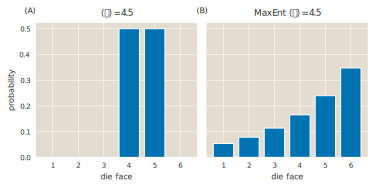

In [6]:
# initialize figure
fig, ax = plt.subplots(1, 2, figsize=(6, 2.5), 
                       sharex=True, sharey=True)

# Define probability distribution of the "wrong inference"
prob = [0, 0, 0, .5, .5, 0]
# Plot the "wrong" distribution
ax[0].bar(samplespace, prob)

# Plot the max ent distribution
ax[1].bar(samplespace, model.probdist())

# Label axis
ax[0].set_xlabel('die face')
ax[1].set_xlabel('die face')

ax[0].set_ylabel('probability')

# Set title for plots
ax[0].set_title(r'$\left\langle x \right\rangle = 4.5$')
ax[1].set_title(r'MaxEnt $\left\langle x \right\rangle = 4.5$')

# Add letter label to subplots
plt.figtext(0.1, 0.93, '(A)', fontsize=8)
plt.figtext(0.50, 0.93, '(B)', fontsize=8)

plt.subplots_adjust(wspace=0.05)

plt.savefig(figdir + 'biased_die_dist.pdf', bbox_inches='tight')

Here we can see that given that we are only told that the average was 4.5 there is no explicit information about certain die faces values not being used whatsoever. So the distribution in (A) is commited to information that we do not posses about the die, making a biased inference. On the other hand since the MaxEnt distribution in (B) maximizes the Shannon entropy subject to our limited information, it is guaranteed to be the least biased with respect to information that we do not posses about the process.

## The mRNA and protein joint distribution $P(m, p)$

The MaxEnt principle can easily be extended to multivariate distributions. For
our particular case we are interested in the mRNA and protein joint distribution
$P(m, p)$. The definition of a moment $\ee{m^x p^y}$ is a natural extension of
\eref{eq_mom_ref} of the form
\begin{equation}
  \ee{m^x p^y} = \sum_m \sum_p m^x p^y P(m, p).
\end{equation}

As a consequence the MaxEnt joint distribution $P_H(m, p)$ is of the form
\begin{equation}
  P_H(m, p) = {1 \over \mathcal{Z}}
              \exp \left( - \sum_{(x,y)} \lambda_{(x,y)} m^x p^y \right),
  \label{eq_maxEnt_joint}
\end{equation}
where $\lambda_{x,y}$ is the Lagrange multiplier associated with the moment
$\ee{m^x p^y}$, and again $\mathcal{Z}$ is the normalization constant given by
\begin{equation}
  \mathcal{Z} = \sum_m \sum_p
              \exp \left( - \sum_{(x,y)} \lambda_{(x,y)} m^x p^y \right).
\end{equation}
Note that the sum in the exponent is taken over all available $(x, y)$ pairs
that define the moment constraints for the distribution.

## The Bretthorst rescaling algorithm

The determination of the Lagrange multipliers suffer from a numerical under and
overflow problem due to the difference in magnitude between the constraints.
This becomes a problem when higher moments are taken into account. The resulting
numerical values for the Lagrange multipliers end up being separated by several
orders of magnitude. For routines such as Newton-Raphson or other minimization
algorithms that can be used to find these Lagrange multipliers these different
scales become problematic.

To get around this problem we implemented a variation to the algorithm due to G.
Larry Bretthorst, E.T. Jaynes' last student. With a very simple argument we can
show that linearly rescaling the constraints, the Lagrange multipliers and the
"rules" for how to compute each of the moments, i.e. each of the individual
products that go into the moment calculation, should converge to the same MaxEnt
distribution. In order to see this let's consider again an univariate
distribution $P_X(x)$ that we are trying to reconstruct given the first two
moments. The MaxEnt distribution can be written as
\begin{equation}
  P_H(x) = {1 \over \mathcal{Z}}
  \exp \left(- \lambda_1 x - \lambda_2 x^2 \right) =
  {1 \over \mathcal{Z}}
  \exp \left(- \lambda_1 x \right) \exp \left( - \lambda_2 x^2 \right).
\end{equation}
We can always rescale the terms in any way and obtain the same result. Let's say
that for some reason we want to rescale the quadratic terms by a factor $a$. We
can define a new Lagrange multiplier $\lambda_2' \equiv {\lambda_2 \over a}$
that compensates for the rescaling of the terms, obtaining
\begin{equation}
  P_H(x) = {1 \over \mathcal{Z}}
  \exp \left(- \lambda_1 x \right) \exp \left( - \lambda_2' ax^2 \right).
\end{equation}
Computationally it might be more efficient to find the numerical value of
$\lambda_2'$ rather than $\lambda_2$ maybe because it is of the same order of
magnitude as $\lambda_1$. Then we can always multiply $\lambda_2'$ by $a$ to
obtain back the constraint for our quadratic term. What this means is that that
we can always rescale the MaxEnt problem to make it numerically more stable,
then we can rescale back to obtain the value of the Lagrange multipliers.

Bretthorst algorithm goes even further by further transforming the constraints
and the variables to make the constraints orthogonal, making the computation
much more effective. We now explain the implementation of the algorithm to our
joint distribution of interest $P(m, p)$.

### Algorithm implementation

Let the matrix $\bb{A}$ contain all the rules used to compute the moments that
serve as constraints, where each entry is of the form
\begin{equation}
  A_{ij} = m_i^{x_j} \cdot p_i^{y_j},
\end{equation}
i.e. the $i^\th$ entry of our sample space consisting of of the product of all
possible pairs ($m, p$) elevated to the appropriate powers $x$ and $y$
associated with the $j^{\text{th}}$ constraint. Let also $\bb{v}$ be a vector
containing all the constraints with each entry of the form
\begin{equation}
  v_j = \ee{m^{x_j} p^{y_j}}.
\end{equation}

That means that the Lagrangian $\mathcal{L}$ to be used for this constrained
maximization problem takes the form
\begin{equation}
  \mathcal{L} = -\sum_i P_i \ln P_i + \lambda_0 \left( 1 - \sum_i P_i \right)
  + \sum_{j>0} \lambda_j \left( v_j - \sum_i A_{ij} P_i \right),
\end{equation}
where $\lambda_0$ is the Lagrange multiplier associated with the normalization
constraint, and $\lambda_j$ is the Lagrange multiplier associated with the
$j^\th$ constraint.

With this notation in hand we now proceed to rescale the problem. The first
step consists of rescaling the rules to compute the entries of matrix $\bb{A}$
as
\begin{equation}
  A_{ij}' = {A_{ij} \over G_j},
\end{equation}
where $G_j$ serves to normalize the moments such that all the Lagrange
multipliers are of the same order of magnitude. This normalization satisfies
\begin{equation}
G_j^2 = \sum_i A_{ij}^2,
\end{equation}
or in terms of our particular problem
\begin{equation}
G_j^2 = \sum_m \sum_p \left( m^{x_j} p^{y_j} \right)^2.
\end{equation}

Since we rescale the rules to compute the constraints, the constraints must
also be rescaled simply as
\begin{equation}
v_j' = \ee{m^{x_j} p^{y_j}}' = {\ee{m^{x_j} p^{y_j}} \over G_j}.
\end{equation}

The Lagrange multipliers must compensate this rescaling since at the end of the
day the probability must add up to the same value. Therefore we rescale the
$\lambda_j$ terms as as
\begin{equation}
\lambda_j' = \lambda_j G_j.
\end{equation}

This rescaling by itself would already improve the algorithm convergence since
now all the Lagrange multipliers would not have drastically different values.
Bretthorst proposes another linear transformation to make the optimization
routine even more efficient. For this we generate orthogonal constraints that
make Newton-Raphson and similar routines converge faster. The transformation is
as follows
\begin{equation}
  A_{ik}'' = \sum_j {e}_{jk} A_{ij}',
\end{equation}
for the entires of matrix $\bb{A}$, and
\begin{equation}
  v_k'' = \sum_j {e}_{jk} u_j',
\end{equation}
for entires of the constraint vector $\bb{v}$, finally
\begin{equation}
  \lambda_k'' = \sum_j {e}_{jk} \beta_j,
\end{equation}
for the Lagrange multipliers. Here ${e}_{jk}$ is the $j^\th$ component
of the $k^\th$ eigenvector of the matrix $\bb{E}$ with entries
\begin{equation}
  {E}_{kj} = \sum_i {A}_{ik}' {A}_{ij}'.
\end{equation}

This transformation guarantees that the matrix $\bb{A}''$ has the property
\begin{equation}
  \sum_i A_{ij}'' A_{jk}'' = \beta_j \delta_{jk},
\end{equation}
where $\beta_j$ is the $j^\th$ eigenvalue of the matrix $\bb{E}$ and
$\delta_{jk}$ is the delta function. What this means is that, as desired, the
constraints are orthogonal to each other, improving the algorithm convergence
speed.

There is an extra step that we will add to the algorithm to facilitate convergence. For the `maxentropy` package is better to have constraints that are all close to 1. Since the previous orthogonalization was generating very small constraints we will divide by the smallest of these transformed constraints. Again since it is a linear transformation this should not affect the final result.

#### Defining a function to compute the MaxEnt distribution

Now that we got the algorithm let's define a simple function that takes as inputs the `features` matrix, the list of constraints and the sample space, and it computes the MaxEnt distribution using the Bretthorst algorithm to then return the list of Lagrange Multipliers.

In [7]:
def MaxEnt_bretthorst(constraints, features,
                      algorithm='BFGS', tol=1E-4, paramtol=5E-5, maxiter=1000):
    '''
    Computes the maximum entropy distribution given a list of constraints and a
    matrix with the features associated with each of the constraints using 
    the maxentropy package. In particular this function rescales the problem 
    according to the Bretthorst algorithm to fascilitate the gradient-based 
    convergence to the value of the Lagrange multipliers.

    Parameters
    ----------
    constraints : array-like.
        List of constraints (moments of the distribution).
    features : 2D-array. shape = len(samplespace) x len(constraints)
        List of "rules" used to compute the constraints from the sample space.
        Each column has a rule associated and each row is the computation of
        such rule over the sample space.
        Example: 
            If the ith rule is of the form m**x * p**y, then the ith column
            of features takes every possible pair (m, p) and computes such
            sample space.
    algorithm : string. Default = 'BFGS'
        Algorithm to be used by the maxentropy package. 
        See maxentropy.BaseModel for more information.
    tol : float.
        Tolerance criteria for the convergence of the algorithm.
        See maxentropy.BaseModel for more information.
    paramtol : float.
        Tolerance criteria for the convergence of the parameters.
        See maxentropy.BaseModel for more information.
    maxiter : float.
        Maximum number of iterations on the optimization procedure.
        See maxentropy.BaseModel for more information.
    
    Returns
    -------
    Lagrange : array-like. lenght = len(constraints)
        List of Lagrange multipliers associated with each of the constraints.
    '''
    # Define a dummy samplespace that we don't need since we are giving the
    # matrix of pre-computed features, but the maxentropy package still
    # requires it.
    samplespace = np.zeros(np.max(features.shape))
    
    ##  First rescaling ##
    
    # Compute the factor to be used to re-scale the problem
    rescale_factor = np.sqrt(np.sum(features**2, axis=1))

    # Re-scale the features
    features_rescale = np.divide(features.T, rescale_factor).T
    
    # Re-scale constraints
    constraints_rescale = constraints / rescale_factor
    
    ## Orthogonalization ##
    
    # Compute the matrix from which the eigenvectors must be extracted
    features_mat = np.dot(features_rescale, features_rescale.T)

    # Compute the eigenvectors of the matrix
    trans_eigvals, trans_eigvects = np.linalg.eig(features_mat)

    # Transform the features with the matrix of eigenvectors
    features_trans = np.dot(trans_eigvects, features_rescale)

    # Transform the features with the constraints of eigenvectors
    constraints_trans = np.dot(trans_eigvects, constraints_rescale)

    ## Second rescaling ##
    
    # Find the absolute value of the smallest constraint that will be used
    # to rescale again the problem
    scale_min = np.min(np.abs(constraints_trans))

    # Scale by dividing by this minimum value to have features and
    # constraints close to 1
    features_trans_scale = features_trans / scale_min
    constraints_trans_scale = constraints_trans / scale_min
    
    ## Computing the MaxEnt distribution ##
    
    # Define the minimum entropy 
    model = MinDivergenceModel(features_trans_scale, samplespace)
    
    # Set model features
    model.algorithm = algorithm
    model.tol = tol
    model.paramstol = paramtol
    model.maxiter = maxiter
    model.callingback = True # TBH I don't know what this does but it is needed
                             # for the damn thing to work
    
    # Change the dimensionality of the array
    # step required by the maxentropy package.
    X = np.reshape(constraints_trans_scale, (1, -1))
    
    # Fit the model
    model.fit(X)
    
    ## Transform back the Lagrange multipliers ##
    
    # Extract params
    params = model.params

    # peroform first rescaling
    params = params / scale_min

    # Transform back from the orthogonalization
    params = np.dot(np.linalg.inv(trans_eigvects), params)

    # Perform second rescaling
    params = params / rescale_factor

    return params

Once we have the Lagrange multipliers we can compute the probability mass function for whichever entry. Let's define a vectorized function that returns a 2D matrix probability distribution given an mRNA and protein sample space along with al ist of Lagrange multipliers.

In [8]:
def maxEnt_from_lagrange(mRNA, protein, lagrange, 
                         exponents=[(1, 0), (2, 0), (3, 0), 
                                   (0, 1), (0, 2), (1, 1)], log=False):
    '''
    Computes the mRNA and protein joint distribution P(m, p) as approximated
    by the MaxEnt methodology given a set of Lagrange multipliers.
    Parameters
    ----------
    mRNA, protein : array-like.
        Sample space for both the mRNA and the protein.
    lagrange : array-like.
        Array containing the value of the Lagrange multipliers associated
        with each of the constraints.
    exponents : list. leng(exponents) == len(lagrange)
        List containing the exponents associated with each constraint.
        For example a constraint of the form <m**3> has an entry (3, 0)
        while a constraint of the form <m * p> has an entry (1, 1).
    log : bool. Default = False
        Boolean indicating if the log probability should be returned.
    Returns
    -------
    Pmp : 2D-array. len(mRNA) x len(protein)
        2D MaxEnt distribution.
    '''
    # Generate grid of points
    mm, pp = np.meshgrid(mRNA, protein)
    
    # Initialize 3D array to save operations associated with each lagrange
    # multiplier
    operations = np.zeros([len(lagrange), len(protein), len(mRNA)])
    
    # Compute operations associated with each Lagrange Multiplier
    for i, expo in enumerate(exponents):
        operations[i, :, :] = lagrange[i] * mm**expo[0] * pp**expo[1]
    
    # check if the log probability should be returned
    if log:
        return np.sum(operations, axis=0) -\
               sp.special.logsumexp(np.sum(operations, axis=0))
    else:
        return np.exp(np.sum(operations, axis=0) -\
                      sp.special.logsumexp(np.sum(operations, axis=0)))

## Computing the Maximum entropy distribution

In order to test these functions we will use the moment inferences computed from integrating the moment equations and averaging over the cell cycle.

Let's import the data frame containing these moments.

In [28]:
# Load moments for multi-promoter level
df_constraints = pd.read_csv('../../data/csv_maxEnt_dist/' + 
                 'MaxEnt_multi_prom_constraints.csv')

# Remove the zeroth moment column
df_constraints = df_constraints.drop(labels='m0p0', axis=1)

# Drop extra columns of the protein moments
df_constraints = df_constraints.drop(labels=['m0p4', 'm0p5', 'm0p6'], axis=1)

## Working at the protein level

Let's begin our inference working only with the first three protein moments. This will speed up the computation in order to test the approach. We will come back to the mRNA later on.

Let's begin by defining the moments to be used and the sample space for the inference. We will also define our matrix $\bb{A}$ here called `features` to be used to compute the constraints.

In [29]:
# Extract protein moments in constraints
prot_mom =  [x for x in df_constraints.columns if 'm0' in x]
# Define index of moments to be used in the computation
moments = [tuple(map(int, re.findall(r'\d+', s))) for s in prot_mom]

# Define sample space
mRNA_space = np.array([0])  # Dummy space
protein_space = np.arange(0, 8E4)

# Generate sample space as a list of pairs using itertools.
samplespace = list(itertools.product(mRNA_space, protein_space))

# Initialize matrix to save all the features that are fed to the
# maxentropy function
features = np.zeros([len(moments), len(samplespace)])

# Loop through constraints and compute features
for i, mom in enumerate(moments):
    features[i, :] = [ccutils.maxent.feature_fn(x, mom) for x in samplespace]

Now we can build a tidy dataframe that contains the value of the Lagrange multipliers. We will perform this computation in parallel over several cores to speed up the process.

In [30]:
# Indicate if the computation should be performed
fit_dist = True

# Initialize data frame to save the lagrange multipliers.
names = ['operator', 'binding_energy', 'repressor', 'inducer_uM']
# Add names of the constraints
names = names + ['lambda_m' + str(m[0]) + 'p' + str(m[1]) for m in moments]

# Initialize empty dataframe
df_maxEnt = pd.DataFrame([], columns=names)

# Define column names containing the constraints used to fit the distribution
constraints_names = ['m' + str(m[0]) + 'p' + str(m[1]) for m in moments]

if fit_dist:
    # Define function for parallel computation
    def maxEnt_parallel(idx, df):
        # Report on progress
        print('iteration: ',idx)
            
        # Extract constraints
        constraints = df.loc[constraints_names]
        
        # Perform MaxEnt computation
        # We use the Powell method because despite being slower it is more
        # robust than the other implementations.
        Lagrange = MaxEnt_bretthorst(constraints, features, 
                                     algorithm='Powell', 
                                     tol=1E-5, paramtol=1E-5,
                                     maxiter=10000)
        # Save Lagrange multipliers into dataframe
        series = pd.Series(Lagrange, index=names[4::])
        
        # Add other features to series before appending to dataframe
        series = pd.concat([df.drop(constraints_names), series])
        
        return series
    
    # Run the function in parallel
    maxEnt_series = Parallel(n_jobs=6)(delayed(maxEnt_parallel)(idx, df)
                           for idx, df in df_constraints.iterrows())
    
    # Initialize data frame to save list of parameters
    df_maxEnt = pd.DataFrame([], columns=names)

    for s in maxEnt_series:
        df_maxEnt = df_maxEnt.append(s, ignore_index=True)

    df_maxEnt.to_csv(datadir + 'MaxEnt_Lagrange_mult_protein.csv', index=False)
    
# Read resulting values for the multipliers.
df_maxEnt = pd.read_csv(datadir + 'MaxEnt_Lagrange_mult_protein.csv')
df_maxEnt.head()

operator  binding_energy  repressor  inducer_uM  lambda_m0p1   lambda_m0p2  \
0       O1           -15.3        0.0         0.0     0.000309 -1.632168e-08   
1       O1           -15.3        0.0         0.1     0.000309 -1.632168e-08   
2       O1           -15.3        0.0         5.0     0.000309 -1.632168e-08   
3       O1           -15.3        0.0        10.0     0.000309 -1.632168e-08   
4       O1           -15.3        0.0        25.0     0.000309 -1.632168e-08   

    lambda_m0p3       m1p0           m1p1          m1p2      ...       \
0 -8.780785e-14  16.092691  159058.599136  1.891230e+09      ...        
1 -8.780785e-14  16.092691  159058.599136  1.891230e+09      ...        
2 -8.780785e-14  16.092691  159058.599136  1.891230e+09      ...        
3 -8.780785e-14  16.092691  159058.599136  1.891230e+09      ...        
4 -8.780785e-14  16.092691  159058.599136  1.891230e+09      ...        

          m3p0          m3p1          m3p2          m3p3           m4p0  \
0  9290.230622  1.018551e+08  1.259305e+12  1.661111e+16  298145.197168   
1  9290.230622  1.018551e+08  1.259305e+12  1.661111e+16  298145.197168   
2  9290.230622  1.018551e+08  1.259305e+12  1.661111e+16  298145.197168   
3  9290.230622  1.018551e+08  1.259305e+12  1.661111e+16  298145.197168   
4  9290.230622  1.018551e+08  1.259305e+12  1.661111e+16  298145.197168   

           m4p1          m4p2          m5p0          m5p1          m6p0  
0  3.373151e+09  4.226007e+13  1.099902e+07  1.271531e+11  4.541650e+08  
1  3.373151e+09  4.226007e+13  1.099902e+07  1.271531e+11  4.541650e+08  
2  3.373151e+09  4.226007e+13  1.099902e+07  1.271531e+11  4.541650e+08  
3  3.373151e+09  4.226007e+13  1.099902e+07  1.271531e+11  4.541650e+08  
4  3.373151e+09  4.226007e+13  1.099902e+07  1.271531e+11  4.541650e+08  

[5 rows x 28 columns]

Let's look at some of these distributions. First we will take a look to some PDFs

In [31]:
# Define operators to be included
operators = ['O1', 'O2', 'O3']

# Define repressors to be included
repressors = [22, 260, 1740]

# Define color for operators
# Generate list of colors
col_list = ['Blues_r', 'Oranges_r', 'Greens_r']
col_dict = dict(zip(operators, col_list))

# Define binstep for plot, meaning how often to plot
# an entry
binstep = 100

# Define sample space
mRNA_space = np.array([0])
protein_space = np.arange(0, 1.8E4)

# Initialize plot
fig, ax = plt.subplots(len(repressors), len(operators),
                       figsize=(5, 5), sharex=True, sharey=True)

# Loop through operators
for j, op in enumerate(operators):
    # Loop through repressors
    for i, rep in enumerate(repressors):
        # Set ticks in scientific notation
        ax[i, j].yaxis.set_major_formatter(mpl.ticker.ScalarFormatter(
                                        useMathText=True,
                                        useOffset=False))

        # Extract the multipliers for a specific strain
        df_sample = df_maxEnt[(df_maxEnt.operator == op) &
                              (df_maxEnt.repressor == rep)]

        # Group multipliers by inducer concentration
        df_group = df_sample.groupby('inducer_uM')

        # Define colors for plot
        colors = sns.color_palette(col_dict[op], n_colors=len(df_group)+1)
        
        # Initialize matrix to save probability distributions
        Pp = np.zeros([len(df_group), len(protein_space)])

        # Loop through each of the entries
        for k, (group, data) in enumerate(df_group):
            # Select the Lagrange multipliers
            lagrange_sample =  data.loc[:, [col for col in data.columns 
                                                 if 'lambda' in col]].values[0]

            # Compute distribution from Lagrange multipliers values
            Pp[k, :] = ccutils.maxent.maxEnt_from_lagrange(mRNA_space, 
                                                           protein_space, 
                                                           lagrange_sample,
                                                           exponents=moments).T

            ax[i, j].plot(protein_space[0::binstep], Pp[k, 0::binstep],
                          drawstyle='steps',
                          color='k')
            # Fill between each histogram
            ax[i, j].fill_between(protein_space[0::binstep], Pp[k, 0::binstep],
                           color=colors[k], alpha=0.8, step='pre')

            
        # Add x label to lower plots
        if i==2:
            ax[i, j].set_xlabel('protein / cell')   
            
        # Add y label to left plots
        if j==0:
            ax[i, j].set_ylabel('probability')
        
        # Add operator top of colums
        if i==0:
            label = r'$\Delta\epsilon_r$ = {:.1f} $k_BT$'.\
                    format(df_sample.binding_energy.unique()[0])
            ax[i, j].set_title(label, bbox=dict(facecolor='#ffedce'))
            
        # Add repressor copy number to right plots
        if j==2:
            # Generate twin axis
            axtwin = ax[i, j].twinx()
            # Remove ticks
            axtwin.get_yaxis().set_ticks([])
            # Set label
            axtwin.set_ylabel(r'rep. / cell = {:d}'.format(rep),
                              bbox=dict(facecolor='#ffedce'))
            # Remove residual ticks from the original left axis
            ax[i, j].tick_params(color='w', width=0)

# Change ylim
ax[0, 0].set_ylim([0, 5E-4])
# Adjust spacing between plots
plt.subplots_adjust(hspace=0.08, wspace=0.02)

# Save figure
plt.savefig(figdir + 'PMF_grid_protein.pdf', bbox_inches='tight')

Now let's look at the same plot, but this time showing the CDF.

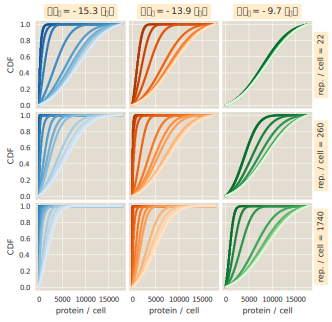

In [32]:
# Define operators to be included
operators = ['O1', 'O2', 'O3']

# Define repressors to be included
repressors = [22, 260, 1740]

# Define color for operators
# Generate list of colors
col_list = ['Blues_r', 'Oranges_r', 'Greens_r']
col_dict = dict(zip(operators, col_list))

# Define binstep for plot, meaning how often to plot
# an entry
binstep = 100

# Define sample space
mRNA_space = np.array([0])
protein_space = np.arange(0, 1.8E4)

# Initialize plot
fig, ax = plt.subplots(len(repressors), len(operators),
                       figsize=(5, 5),
                       sharex=True, sharey=True)

# Loop through operators
for j, op in enumerate(operators):
    # Loop through repressors
    for i, rep in enumerate(repressors):
        # Extract the multipliers for a specific strain
        df_sample = df_maxEnt[(df_maxEnt.operator == op) &
                              (df_maxEnt.repressor == rep)]

        # Group multipliers by inducer concentration
        df_group = df_sample.groupby('inducer_uM')

        # Define colors for plot
        colors = sns.color_palette(col_dict[op], n_colors=len(df_group)+1)
        
        # Initialize matrix to save probability distributions
        Pp = np.zeros([len(df_group), len(protein_space)])

        # Loop through each of the entries
        for k, (group, data) in enumerate(df_group):
            # Select the Lagrange multipliers
            lagrange_sample =  data.loc[:, [col for col in data.columns 
                                                 if 'lambda' in col]].values[0]

            # Compute distribution from Lagrange multipliers values
            Pp[k, :] = ccutils.maxent.maxEnt_from_lagrange(mRNA_space, 
                                                           protein_space, 
                                                           lagrange_sample,
                                                           exponents=moments).T

            # CDF plot
            ax[i, j].plot(protein_space[0::binstep], 
                          np.cumsum(Pp[k, :])[0::binstep],
                          drawstyle='steps', color=colors[k],
                          linewidth=2)
             
        # Add x label to lower plots
        if i==2:
            ax[i, j].set_xlabel('protein / cell')   
            
        # Add y label to left plots
        if j==0:
            ax[i, j].set_ylabel('CDF')
        
        # Add operator top of colums
        if i==0:
            label = r'$\Delta\epsilon_r$ = {:.1f} $k_BT$'.\
                    format(df_sample.binding_energy.unique()[0])
            ax[i, j].set_title(label, bbox=dict(facecolor='#ffedce'))
            
        # Add repressor copy number to right plots
        if j==2:
            # Generate twin axis
            axtwin = ax[i, j].twinx()
            # Remove ticks
            axtwin.get_yaxis().set_ticks([])
            # Set label
            axtwin.set_ylabel(r'rep. / cell = {:d}'.format(rep),
                              bbox=dict(facecolor='#ffedce'))
            # Remove residual ticks from the original left axis
            ax[i, j].tick_params(color='w', width=0)

# Adjust spacing between plots
plt.subplots_adjust(hspace=0.02, wspace=0.02)

# Save figure
plt.savefig(figdir + 'CDF_grid_protein.pdf', bbox_inches='tight')

Finally let's take a look at the so-called joy-plots.

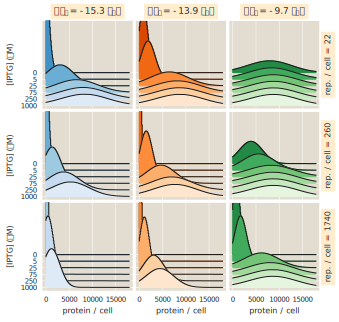

In [33]:
# Define operators to be included
operators = ['O1', 'O2', 'O3']

# Define repressors to be included
repressors = [22, 260, 1740]

# Define concnentration to include in plot
inducer = np.sort(df_maxEnt.inducer_uM.unique())[::2]

# Define color for operators
# Generate list of colors
col_list = ['Blues', 'Oranges', 'Greens']
col_dict = dict(zip(operators, col_list))

# Define binstep for plot, meaning how often to plot
# an entry
binstep = 100

# Define sample space
mRNA_space = np.array([0])
protein_space = np.arange(0, 1.8E4)

# Initialize plot
fig, ax = plt.subplots(len(repressors), len(operators), figsize=(5, 5),
                       sharex=True, sharey=True)

# Define displacement
displacement = 5E-5

# Loop through operators
for j, op in enumerate(operators):
    # Loop through repressors
    for i, rep in enumerate(repressors):

        # Extract the multipliers for a specific strain
        df_sample = df_maxEnt[(df_maxEnt.operator == op) &
                              (df_maxEnt.repressor == rep) &
                              (df_maxEnt.inducer_uM.isin(inducer))]

        # Group multipliers by inducer concentration
        df_group = df_sample.groupby('inducer_uM', sort=True)

        # Extract and invert groups to start from higher to lower
        groups = np.flip([group for group, data in df_group])
        
        # Define colors for plot
        colors = sns.color_palette(col_dict[op], n_colors=len(df_group)+1)
        
        # Initialize matrix to save probability distributions
        Pp = np.zeros([len(df_group), len(protein_space)])

        # Loop through each of the entries
        for k, group in enumerate(groups):
            data = df_group.get_group(group)
            
            # Select the Lagrange multipliers
            lagrange_sample =  data.loc[:, [col for col in data.columns 
                                                 if 'lambda' in col]].values[0]

            # Compute distribution from Lagrange multipliers values
            Pp[k, :] = ccutils.maxent.maxEnt_from_lagrange(mRNA_space, 
                                                           protein_space, 
                                                           lagrange_sample,
                                                           exponents=moments).T

            # Generate PMF plot
            ax[i, j].plot(protein_space[0::binstep], Pp[k, 0::binstep] + k * displacement,
                          drawstyle='steps', lw=1,
                          color='k', zorder=len(df_group) * 2 - (2 * k))
            # Fill between each histogram
            ax[i, j].fill_between(protein_space[0::binstep], Pp[k, 0::binstep] + k * displacement,
                                  [displacement * k] * len(protein_space[0::binstep]), 
                                  color=colors[k], alpha=1, step='pre', 
                                  zorder=len(df_group) * 2 - (2 * k + 1))

        # Add x label to lower plots
        if i==2:
            ax[i, j].set_xlabel('protein / cell')   
            
        # Add y label to left plots
        if j==0:
            ax[i, j].set_ylabel('[IPTG] ($\mu$M)')
        
        # Add operator top of colums
        if i==0:
            label = r'$\Delta\epsilon_r$ = {:.1f} $k_BT$'.\
                    format(df_sample.binding_energy.unique()[0])
            ax[i, j].set_title(label, bbox=dict(facecolor='#ffedce'))
            
        # Add repressor copy number to right plots
        if j==2:
            # Generate twin axis
            axtwin = ax[i, j].twinx()
            # Remove ticks
            axtwin.get_yaxis().set_ticks([])
            # Set label
            axtwin.set_ylabel(r'rep. / cell = {:d}'.format(rep),
                              bbox=dict(facecolor='#ffedce'))
            # Remove residual ticks from the original left axis
            ax[i, j].tick_params(color='w', width=0)

# Change ylim
ax[0, 0].set_ylim([-3E-5, 3.5E-4 + len(df_group) * displacement])
# Adjust spacing between plots
plt.subplots_adjust(hspace=0.02, wspace=0.02)

# Set y axis ticks
yticks = np.arange(len(df_group)) * displacement
yticklabels = [int(x) for x in groups]

ax[0, 0].yaxis.set_ticks(yticks)
ax[0, 0].yaxis.set_ticklabels(yticklabels)

# Save figure
plt.savefig(figdir + 'PMF_grid_joyplot_protein.pdf', bbox_inches='tight')
plt.savefig(figdir + 'PMF_grid_joyplot_protein.svg', bbox_inches='tight')

## Working at the mRNA level

Let's now work at the mRNA level. We will take all mRNA moments of the distribution

In [34]:
# Extract protein moments in constraints
mRNA_mom =  [x for x in df_constraints.columns if 'p0' in x]
# Define index of moments to be used in the computation
moments = [tuple(map(int, re.findall(r'\d+', s))) for s in mRNA_mom]

# Define sample space
mRNA_space = np.arange(0, 1E2)
protein_space = np.array([0])  # Dummy space

# Generate sample space as a list of pairs using itertools.
samplespace = list(itertools.product(mRNA_space, protein_space))

# Initialize matrix to save all the features that are fed to the
# maxentropy function
features = np.zeros([len(moments), len(samplespace)])

# Loop through constraints and compute features
for i, mom in enumerate(moments):
    features[i, :] = [ccutils.maxent.feature_fn(x, mom) for x in samplespace]

Now we can build a tidy dataframe that contains the value of the Lagrange multipliers. We will perform this computation in parallel over several cores to speed up the process.

In [35]:
# Indicate if the computation should be performed
fit_dist = True

# Initialize data frame to save the lagrange multipliers.
names = ['operator', 'binding_energy', 'repressor', 'inducer_uM']
# Add names of the constraints
names = names + ['lambda_m' + str(m[0]) + 'p' + str(m[1]) for m in moments]

# Initialize empty dataframe
df_maxEnt = pd.DataFrame([], columns=names)

# Define column names containing the constraints used to fit the distribution
constraints_names = ['m' + str(m[0]) + 'p' + str(m[1]) for m in moments]

if fit_dist:
    # Define function for parallel computation
    def maxEnt_parallel(idx, df):
        # Report on progress
        print('iteration: ',idx)
            
        # Extract constraints
        constraints = df.loc[constraints_names]
        
        # Perform MaxEnt computation
        # We use the Powell method because despite being slower it is more
        # robust than the other implementations.
        Lagrange = MaxEnt_bretthorst(constraints, features, 
                                     algorithm='Powell',
        tol=1E-5, paramtol=1E-5, maxiter=8000)
        # Save Lagrange multipliers into dataframe
        series = pd.Series(Lagrange, index=names[4::])
        
        # Add other features to series before appending to dataframe
        series = pd.concat([df.drop(constraints_names), series])
        
        return series
    
    # Run the function in parallel
    maxEnt_series = Parallel(n_jobs=6)(delayed(maxEnt_parallel)(idx, df)
                           for idx, df in df_constraints.iterrows())
    
    # Initialize data frame to save list of parameters
    df_maxEnt = pd.DataFrame([], columns=names)

    for s in maxEnt_series:
        df_maxEnt = df_maxEnt.append(s, ignore_index=True)

    df_maxEnt.to_csv(datadir + 'MaxEnt_Lagrange_mult_mRNA.csv', index=False)
    
# Read resulting values for the multipliers.
df_maxEnt = pd.read_csv(datadir + 'MaxEnt_Lagrange_mult_mRNA.csv')

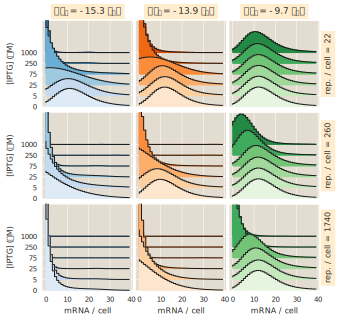

In [36]:
# Define operators to be included
operators = ['O1', 'O2', 'O3']

# Define repressors to be included
repressors = [22, 260, 1740]

# Define concnentration to include in plot
inducer = np.sort(df_maxEnt.inducer_uM.unique())[::2]

# Define color for operators
# Generate list of colors
col_list = ['Blues', 'Oranges', 'Greens']
col_dict = dict(zip(operators, col_list))

# Define binstep for plot, meaning how often to plot
# an entry
binstep = 1

# Define sample space
mRNA_space = np.arange(0, 40)
protein_space = np.array([0])

# Initialize plot
fig, ax = plt.subplots(len(repressors), len(operators), figsize=(5, 5),
                       sharex=True, sharey=True)

# Define displacement
displacement = 3E-2

# Loop through operators
for j, op in enumerate(operators):
    # Loop through repressors
    for i, rep in enumerate(repressors):
        
        # Extract the multipliers for a specific strain
        df_sample = df_maxEnt[(df_maxEnt.operator == op) &
                              (df_maxEnt.repressor == rep) &
                              (df_maxEnt.inducer_uM.isin(inducer))]

        # Group multipliers by inducer concentration
        df_group = df_sample.groupby('inducer_uM', sort=True)

        # Extract and invert groups to start from higher to lower
        groups = np.flip([group for group, data in df_group])
        
        # Define colors for plot
        colors = sns.color_palette(col_dict[op], n_colors=len(df_group)+1)
        
        # Initialize matrix to save probability distributions
        Pm = np.zeros([len(df_group), len(mRNA_space)])

         # Loop through each of the entries
        for k, group in enumerate(groups):
            data = df_group.get_group(group)
            
            # Select the Lagrange multipliers
            lagrange_sample =  data.loc[:, [col for col in data.columns 
                                                 if 'lambda' in col]].values[0]

            # Compute distribution from Lagrange multipliers values
            Pm[k, :] = ccutils.maxent.maxEnt_from_lagrange(mRNA_space, 
                                                           protein_space, 
                                                           lagrange_sample,
                                                           exponents=moments)

            # Generate PMF plot
            ax[i, j].plot(mRNA_space[0::binstep], Pm[k, 0::binstep] + k * displacement,
                          drawstyle='steps', lw=1,
                          color='k', zorder=len(df_group) * 2 - (2 * k))
            # Fill between each histogram
            ax[i, j].fill_between(mRNA_space[0::binstep], Pm[k, 0::binstep] + k * displacement,
                                  [displacement * k] * len(mRNA_space[0::binstep]), 
                                  color=colors[k], alpha=1, step='pre', 
                                  zorder=len(df_group) * 2 - (2 * k + 1))

        # Add x label to lower plots
        if i==2:
            ax[i, j].set_xlabel('mRNA / cell')   
            
        # Add y label to left plots
        if j==0:
            ax[i, j].set_ylabel(r'[IPTG] ($\mu$M)')
        
        # Add operator top of colums
        if i==0:
            label = r'$\Delta\epsilon_r$ = {:.1f} $k_BT$'.\
                    format(df_sample.binding_energy.unique()[0])
            ax[i, j].set_title(label, bbox=dict(facecolor='#ffedce'))
            
        # Add repressor copy number to right plots
        if j==2:
            # Generate twin axis
            axtwin = ax[i, j].twinx()
            # Remove ticks
            axtwin.get_yaxis().set_ticks([])
            # Set label
            axtwin.set_ylabel(r'rep. / cell = {:d}'.format(rep),
                              bbox=dict(facecolor='#ffedce'))
            # Remove residual ticks from the original left axis
            ax[i, j].tick_params(color='w', width=0)

# Change ylim
ax[0, 0].set_ylim([-3E-3, 6E-2 + len(df_group) * displacement])
# Adjust spacing between plots
plt.subplots_adjust(hspace=0.05, wspace=0.02)

# Set y axis ticks
yticks = np.arange(len(df_group)) * displacement
yticklabels = [int(x) for x in df_group.groups.keys()]

ax[0, 0].yaxis.set_ticks(yticks)
ax[0, 0].yaxis.set_ticklabels(yticklabels)

# Set x ticks every 10 mRNA
ax[0, 0].xaxis.set_ticks(np.arange(0, 50, 10))

# Save figure
plt.savefig(figdir + 'PMF_grid_joyplot_mRNA.pdf', bbox_inches='tight')
plt.savefig(figdir + 'PMF_grid_joyplot_mRNA.svg', bbox_inches='tight')

## Extending the range of repressors.

In order to explore the trend that the channel capacity will have for higher number of repressors we need to infer the distributions for a larger range of repressor copy numbers. So let's repeat these inferences at the protein level using a set of constraints for up to $10^6$ repressors per cell.

Let's first read the constraints

In [17]:
# Load moments for multi-promoter level
df_constraints = pd.read_csv('../../data/csv_maxEnt_dist/' + 
                 'MaxEnt_multi_prom_ext_R.csv')

# Remove the zeroth moment column
df_constraints = df_constraints.drop(labels='m0p0', axis=1)

Let's now define the sample space and all the necessary features to compute the MaxEnt protein distributions.

In [18]:
# Extract protein moments in constraints
prot_mom =  [x for x in df_constraints.columns if 'm0' in x]
# Define index of moments to be used in the computation
moments = [tuple(map(int, re.findall(r'\d+', s))) for s in prot_mom]

# Define sample space
mRNA_space = np.array([0])  # Dummy space
protein_space = np.arange(0, 8E4)

# Generate sample space as a list of pairs using itertools.
samplespace = list(itertools.product(mRNA_space, protein_space))

# Initialize matrix to save all the features that are fed to the
# maxentropy function
features = np.zeros([len(moments), len(samplespace)])

# Loop through constraints and compute features
for i, mom in enumerate(moments):
    features[i, :] = [ccutils.maxent.feature_fn(x, mom) for x in samplespace]

And now we are ready to perform the computation.

In [19]:
# Indicate if the computation should be performed
fit_dist = False

# Initialize data frame to save the lagrange multipliers.
names = ['operator', 'binding_energy', 'repressor', 'inducer_uM']
# Add names of the constraints
names = names + ['lambda_m' + str(m[0]) + 'p' + str(m[1]) for m in moments]

# Initialize empty dataframe
df_maxEnt = pd.DataFrame([], columns=names)

# Define column names containing the constraints used to fit the distribution
constraints_names = ['m' + str(m[0]) + 'p' + str(m[1]) for m in moments]

if fit_dist:
    # Define function for parallel computation
    def maxEnt_parallel(idx, df):
        # Report on progress
        print('iteration: ',idx)
            
        # Extract constraints
        constraints = df.loc[constraints_names]
        
        # Perform MaxEnt computation
        # We use the Powell method because despite being slower it is more
        # robust than the other implementations.
        Lagrange = MaxEnt_bretthorst(constraints, features, 
                                     algorithm='Powell', 
                                     tol=1E-5, paramtol=1E-5,
                                     maxiter=8000)
        # Save Lagrange multipliers into dataframe
        series = pd.Series(Lagrange, index=names[4::])
        
        # Add other features to series before appending to dataframe
        series = pd.concat([df.drop(constraints_names), series])
        
        return series
    
    # Run the function in parallel
    maxEnt_series = Parallel(n_jobs=6)(delayed(maxEnt_parallel)(idx, df)
                           for idx, df in df_constraints.iterrows())
    
    # Initialize data frame to save list of parameters
    df_maxEnt = pd.DataFrame([], columns=names)

    for s in maxEnt_series:
        df_maxEnt = df_maxEnt.append(s, ignore_index=True)

    df_maxEnt.to_csv(datadir + 'MaxEnt_Lagrange_mult_protein_ext_R.csv',
                     index=False)